In [ ]:
from skimage.io import imread
from micromorph.bacteria.shape_analysis import get_medial_axis, smooth_medial_axis, get_bacteria_boundary

In [63]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['mathtext.default'] = 'regular'
mpl.rc('font', serif='Arial') 
plt.rcParams['svg.fonttype'] = 'none'

In [ ]:
image_path = r"..\test-data\long-cells\SC36-1.tif" 
mask_path = r"..\test-data\long-cells\SC36_mask-1.tif"

image = imread(image_path)
mask = imread(mask_path)
mask = mask == 6  # only keep cells with label 6

In [71]:
analysis_options = {'fit_type': 'fluorescence',
                    'pxsize': 65,
                    'psfFWHM': 400,
                    'spline_val': 5, # 5
                    'spline_spacing': 0.1, # 0.25
                    'boundary_smoothing_factor': 70
                    }

In [ ]:
boundary = get_bacteria_boundary(mask, analysis_options['boundary_smoothing_factor'])
med_ax = get_medial_axis(mask)
med_ax_smooth = smooth_medial_axis(med_ax, boundary, spline_spacing=analysis_options['spline_spacing'], spline_val=analysis_options['spline_val'])


In [ ]:
%matplotlib qt
plt.imshow(image)
# plot boundary
plt.plot(boundary[:, 0], boundary[:, 1], 'r', linewidth=0.5)
plt.plot(med_ax_smooth[:, 0], med_ax_smooth[:, 1], 'b', linewidth=1)

In [30]:
import numpy as np
# calculat the menger curvature of med_ax_smooth
def calculate_menger_curvature(points):
    """
    Calculate the Menger curvature of a set of points.
    """
    n = len(points)
    curvature = np.zeros(n)
    
    for i in range(1, n - 1):
        p1 = points[i - 1]
        p2 = points[i]
        p3 = points[i + 1]
        
        # Calculate the area of the triangle formed by p1,
        # p2, and p3 using Hero's formula
        a = np.linalg.norm(p2 - p1)
        b = np.linalg.norm(p3 - p2)
        c = np.linalg.norm(p1 - p3)
        s = (a + b + c) / 2
        area = np.sqrt(s * (s - a) * (s - b) * (s - c))

        # Calculate the radius of the circumcircle
        radius = (a * b * c) / (4 * area) if area != 0 else np.inf
        curvature[i] = 1 / radius if radius != 0 else 0

    return curvature

menger_curvature = calculate_menger_curvature(med_ax_smooth)

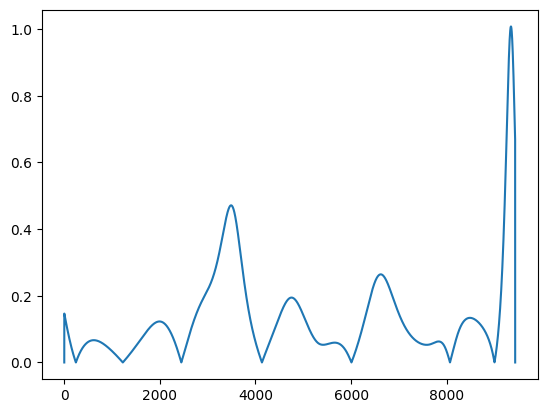

In [45]:
# plt.imshow(image)
plt.plot(menger_curvature/0.065, '-')

In [119]:
# current_bacteria_data = Bacteria(image, mask, options=analysis_options)

In [32]:
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [46]:
# need to calculate arclength of the medial axis, so we can use it for smoothing
distances = np.sqrt(np.sum(np.diff(med_ax_smooth, axis=0) ** 2, axis=1))
distances = np.concatenate((np.array([0]), distances))  # add 0 for the first point
total_arclength_distance = np.cumsum(distances)  # cumulative sum to get the arclength

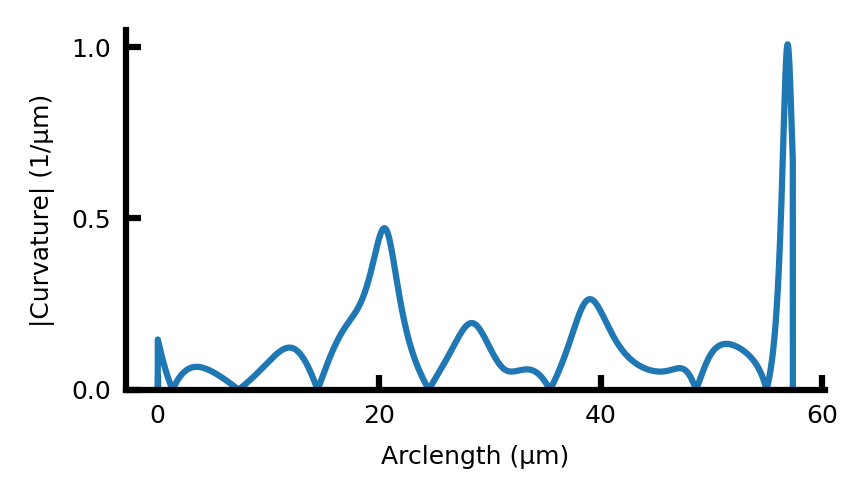

In [ ]:
%matplotlib inline
mm_to_inch = 1/25.4

fig, ax = plt.subplots(figsize=(76.322*mm_to_inch, 39.563*mm_to_inch), dpi=300)

plt.plot(total_arclength_distance*0.065, menger_curvature/0.065)

# remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# inward ticks
ax.tick_params(axis='both', direction='in')

# set linewidth to 1.5 for both spine and ticks
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)
ax.tick_params(width=1.5)

# set all font sizes to 8
ax.tick_params(labelsize=6)
ax.set_ylim(0, 1.05)
ax.set_yticks([0, 0.5, 1])
ax.set_xticks([0,20, 40, 60])

ax.set_xlabel('Arclength (µm)', fontsize=6)
ax.set_ylabel('|Curvature| (1/µm)', fontsize=6)

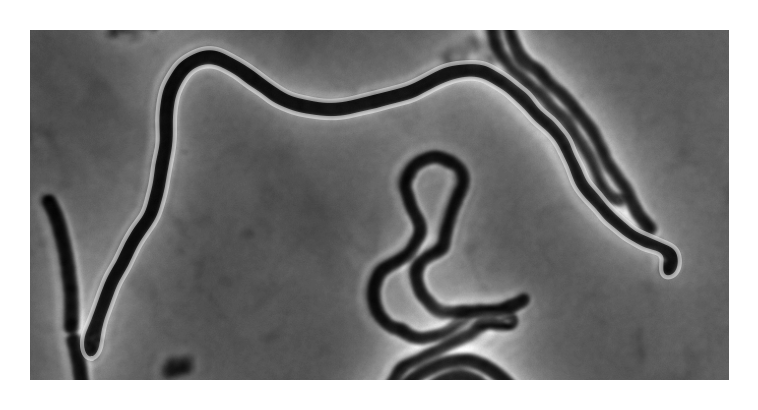

In [ ]:
%matplotlib inline
mm_to_inch = 1/25.4

fig, ax = plt.subplots(figsize=(76.322*mm_to_inch, 39.563*mm_to_inch), dpi=300)
# plot medial axis, with colourmap based on menger curvature
plt.imshow(image, cmap='gray')
# sc = ax.scatter(med_ax_smooth[:, 0], med_ax_smooth[:, 1], c=menger_curvature/65, cmap='gist_rainbow', s=5)
# plot boundary
plt.plot(boundary[:, 0], boundary[:, 1], linewidth=1, color='w', alpha=0.5)

# set axis ratios to 1,1,1
ax.set_aspect('equal', adjustable='box')

# invert y axis direction
ax.yaxis.set_inverted(True)

# hide axes
ax.axis('off')

plt.show()